# Modeling

This notebook aims to build machine learning models to predict rental prices of properties. Four different methods, namely Linear Regression, Decision Trees, Random Forests, and Gradient Boosting will be compared using metrics such as R^2, MAE, and MSE.

## Importing

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.tree import export_graphviz

In [41]:
df = pd.read_csv('../data/processed/clean_kelowna_housing_data.csv')

In [42]:
grouped = df.groupby('Type')
# Group the df by 'Type' column, so I can check for IQR in all types

q1 = grouped["price"].transform(lambda x: x.quantile(0.25))
q3 = grouped["price"].transform(lambda x: x.quantile(0.75))

iqr = q3 - q1

upper_bound = q3 + (1.5 * iqr)
lower_bound = q1 - (1.5 * iqr)
# Calculate the upper and lower bounds using the interquartile range

outliers = df[df["price"].gt(upper_bound) | df["price"].lt(lower_bound)]

outliers
# print all outliers

,name,price,address,Type,nbeds,nbath,laundry,heating,parking,air_conditioner,furnished,animal_friendly,Area,lat,lng,Walk Score,Bike Score,Transit Score
59,6 beds 2 baths house,7500,"west kelowna, bc",House,6,2,in-unit laundry,central heating,garage parking,central ac,Not specified,No pets,1200,49.85902,-119.58413,6,23,-1
89,6 beds 6 baths house,8000,"west kelowna, bc",House,6,6,in-unit laundry,electric heating,street parking,ac available,unfurnished,No pets,5800,49.85902,-119.58413,6,23,-1
286,4 beds 4 5 baths townhouse,6360,"kelowna, bc",Townhouse,4,4,Not specified,Not specified,Not specified,Not specified,Not specified,No pets,2016,49.88698,-119.49661,64,98,59
423,7 beds 3 baths house,6000,"kelowna, bc, v1x 2j5",House,7,3,in-unit laundry,heating available,parking available,ac available,Not specified,No pets,3200,49.89529,-119.39641,51,83,50
452,4 beds 4 baths house,10800,"kelowna, bc, v1y",House,4,4,in-unit laundry,central heating,garage parking,central ac,unfurnished,No pets,3300,49.88698,-119.49661,64,98,59
711,4 beds 3 baths house,5500,"kelowna, bc, v1p 1a1",House,4,3,laundry in building,central heating,garage parking,central ac,Not specified,dog and cat friendly,2928,49.88056,-119.36212,14,14,24
802,private room for rent,1450,"kelowna, bc, v1y 5n7",Room,1,1,in-unit laundry,gas heating,street parking,central ac,unfurnished,No pets,150,49.87628,-119.48731,52,92,57
803,private room for rent,1450,"kelowna, bc, v1y 5n7",Room,1,1,in-unit laundry,Not specified,Not specified,central ac,unfurnished,dog and cat friendly,150,49.87628,-119.48731,52,92,57
819,4 beds 3 baths house,6600,"west kelowna, bc, v1z 4b7",House,4,3,in-unit laundry,central heating,garage parking,central ac,Not specified,No pets,4000,49.88363,-119.54893,0,6,-1
840,furnished 2 bedroom apt,1500,"peachland, bc",Room,1,1,Not specified,Not specified,Not specified,Not specified,Not specified,No pets,150,49.77387,-119.73592,32,60,-1


In [43]:
df = df.drop(outliers.index)

In [44]:
data = pd.get_dummies(df.drop(columns = {'name', 'address', 'Transit Score'}))
data

,price,nbeds,nbath,Area,lat,lng,Walk Score,Bike Score,Type_Apartment/Condo,Type_House,...,air_conditioner_Not specified,air_conditioner_ac available,air_conditioner_central ac,furnished_Not specified,furnished_furnished,furnished_unfurnished,animal_friendly_No pets,animal_friendly_cat friendly,animal_friendly_dog and cat friendly,animal_friendly_dog friendly
0,3300,3,3,1371,49.87816,-119.47675,54,96,0,0,...,0,0,1,0,0,1,1,0,0,0
1,2000,2,1,914,49.83173,-119.62367,43,49,0,1,...,1,0,0,1,0,0,0,0,1,0
2,570,1,1,150,49.83173,-119.62367,43,49,0,0,...,0,1,0,0,0,1,0,1,0,0
3,2900,3,2,1371,49.83173,-119.62367,43,49,0,0,...,0,0,1,1,0,0,0,0,1,0
4,3800,4,2,2500,49.83173,-119.62367,43,49,0,1,...,1,0,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1258,950,1,1,1200,49.86395,-119.48816,75,97,0,1,...,0,0,1,1,0,0,1,0,0,0
1259,1100,1,1,150,49.53912,-119.56932,0,28,0,0,...,1,0,0,0,1,0,0,0,1,0
1260,1100,1,1,150,49.84618,-119.60449,14,24,0,0,...,0,0,1,0,1,0,1,0,0,0
1261,2800,2,1,1200,49.90500,-119.46058,15,52,0,1,...,1,0,0,0,0,1,1,0,0,0


I have selected the 10 most important variables for my models based on the results of a Random Forest model. I generated a plot to visualize the importance of each variable and decided to only keep these 10 columns to enhance the predictive power of other models.
![Importance plot](../images/importance_plot.png)

In [45]:
X = data[['nbeds', 'Area', 'Type_Apartment/Condo', 'nbath', 'Bike Score', 'Walk Score', 'lng', 'lat', 'laundry_in-unit laundry', 'heating_central heating']]  # all rows, no label
y = data.loc[:, 'price']  # all rows, label only
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# I decided to make 80%/20% train-test split

## Linear regression

In [46]:
# Fit multiple linear regression model to training data
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict rental prices on testing data
y_pred = lr_model.predict(X_test)

# Evaluate performance of model
lr_r2 = r2_score(y_test, y_pred)
lr_mse = mean_squared_error(y_test, y_pred)
lr_mae = mean_absolute_error(y_test, y_pred)

print('R^2 in linear regression:', lr_r2)
print('MSE in linear regression:', lr_mse)
print('MAE in linear regression:', lr_mae)

R^2 in linear regression: 0.7356026563139852
MSE in linear regression: 214739.77763556223
MAE in linear regression: 316.66984197462625


In [47]:
# Generate learning curve
train_sizes, train_scores, test_scores = learning_curve(lr_model, X, y, cv=5, scoring = 'neg_mean_squared_error', shuffle = True)

# Calculate mean training and validation scores
train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -test_scores.mean(axis = 1)

# Because learning curve use negative mean squared error, I put - sign before calculating mean

print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_sizes))
print('\n', '-' * 20) # separator
print('\nMean validation scores\n\n',pd.Series(validation_scores_mean, index = train_sizes))

Mean training scores

 99     202912.273262
322    222565.558869
546    218758.124776
769    224425.230708
993    222202.524441
dtype: float64

 --------------------

Mean validation scores

 99     292154.017984
322    250606.144325
546    242782.311602
769    238240.397715
993    237335.061691
dtype: float64


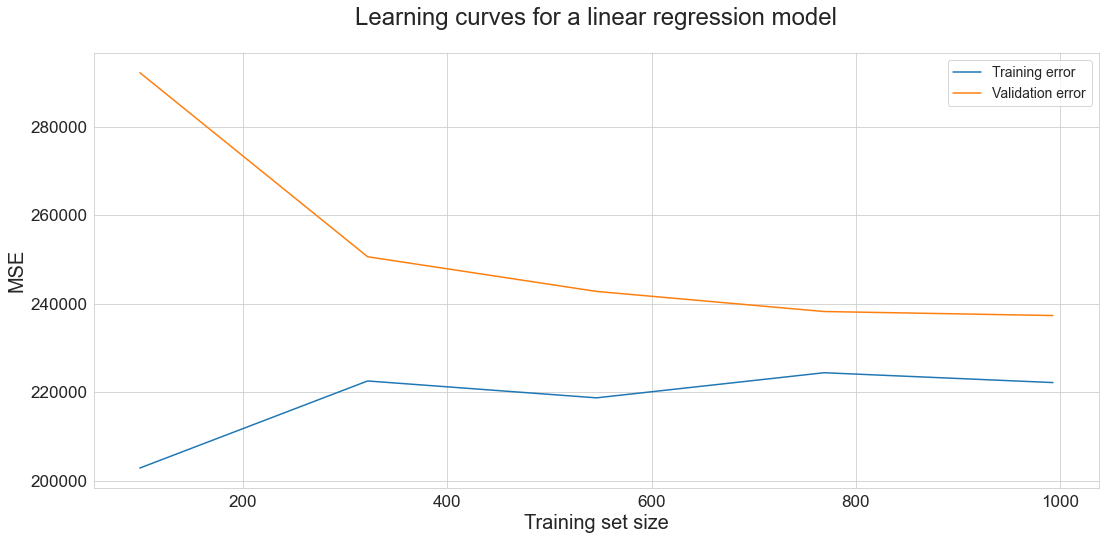

In [48]:
plt.figure(figsize=(18, 8))
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')

# Set labels and title
plt.ylabel('MSE', fontsize = 20)
plt.xlabel('Training set size', fontsize = 20)
plt.title('Learning curves for a linear regression model', fontsize = 24, y = 1.05)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.legend(fontsize=14)

The plot depicts the relationship between the size of the training set and the training and validation error. As the size of the training set increases, both errors tend to converge, which indicates that the model is not overfitting the data. However, the results may not be the best since the model being used, linear regression, is the simplest one available.

In [49]:
residuals = y_test - y_pred

# Get summary statistics of the residuals using describe()
residuals.describe()

count     249.000000
mean      -45.469094
std       462.092944
min     -1770.294300
25%      -261.035595
50%       -42.845707
75%       174.925118
max      2391.215249
Name: price, dtype: float64

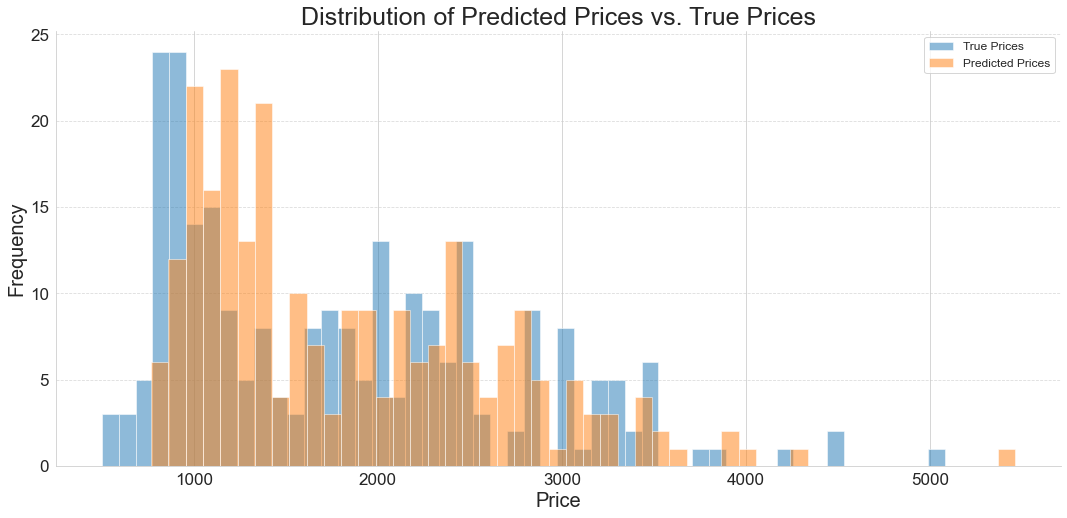

In [50]:
fig, ax = plt.subplots(figsize=(18, 8))

# create a histogram with both sets of data
ax.hist(y_test, alpha=0.5, label='True Prices', bins=50)
ax.hist(y_pred, alpha=0.5, label='Predicted Prices', bins=50)

# set axis labels and title
ax.set_xlabel('Price', fontsize=20)
ax.set_ylabel('Frequency', fontsize=20)
ax.set_title('Distribution of Predicted Prices vs. True Prices', fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=17)

# set legend location and font size
ax.legend(fontsize=12, loc='upper right')

# remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# add gridlines
ax.grid(axis='y', linestyle='--', alpha=0.7)

# show the plot
plt.show()

Here we can observe the distribution plot of predicted price versus actual price for linear regression. As shown, the model performs well in predicting prices in general with the distribution of predicted prices closely resembling the distribution of actual prices. However, the model struggles with predicting lower prices.

## Decision trees

Now i will use the decision trees model. Compared to linear regression, decision trees are more complex and should be able to produce better results.

In [51]:
# Fit decision trees model to training data
dtree_model = DecisionTreeRegressor(random_state=46, ccp_alpha = 0.001)

# Define the parameter grid for pruning
param_grid = {
    'max_depth': [2, 4, 5],
    'min_samples_leaf': [1, 2, 3],
    'max_leaf_nodes': [5, 10, 13, 15],
    'min_samples_split': [3, 5, 7],
}

grid_search = GridSearchCV(estimator=dtree_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
best_dtree = grid_search.best_estimator_

# Train the model on the training set using the best hyperparameters
best_dtree.fit(X_train, y_train)

# Predict rental prices on testing data
y_pred = best_dtree.predict(X_test)

dtree_r2 = r2_score(y_test, y_pred)
dtree_mse = mean_squared_error(y_test, y_pred)
dtree_mae = mean_absolute_error(y_test, y_pred)
print("Rˆ2 in decision trees:", dtree_r2)
print("MSE in decision trees:", dtree_mse)
print("MAE in decision trees:", dtree_mae)

Rˆ2 in decision trees: 0.7719954902121474
MSE in decision trees: 185182.0334091301
MAE in decision trees: 295.77507403546383


To identify the best parameters for the decision trees model, I am using a grid search. The grid search algorithm tests different combinations of hyperparameters and selects the set of parameters that results in the lowest error.

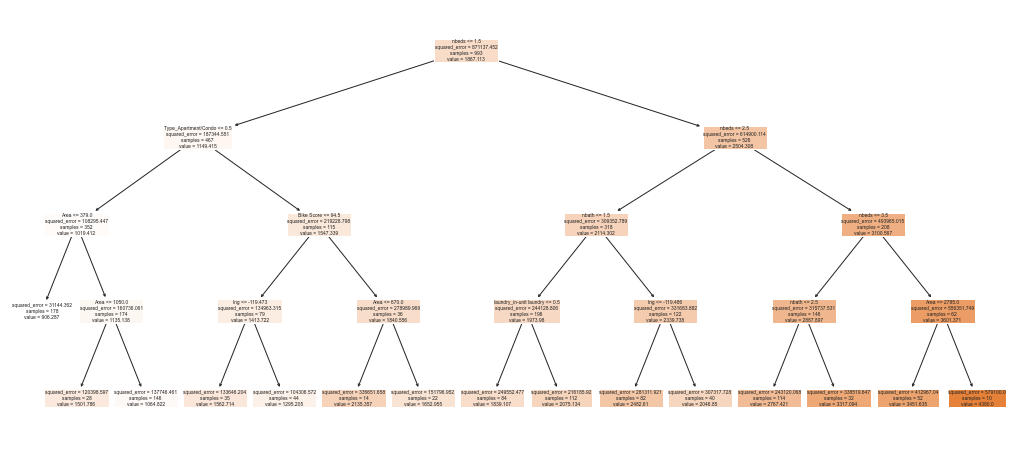

In [52]:
# Plot decision tree
plt.figure(figsize=(18, 8))
plot_tree(best_dtree, feature_names = X.columns, filled=True)
plt.savefig('../images/decision_tree.png', dpi=500)
plt.show()

This plot displays the decision tree that was generated for this regression problem. The resulting plot was saved in the 'images' folder to provide a clearer and more detailed view of the tree.

In [53]:
# Generate learning curve
train_sizes, train_scores, test_scores = learning_curve(best_dtree, X, y, cv=5, scoring = 'neg_mean_squared_error', shuffle = True)

# Calculate mean training and validation scores
train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -test_scores.mean(axis = 1)

print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_sizes))
print('\n', '-' * 20) # separator
print('\nMean validation scores\n\n',pd.Series(validation_scores_mean, index = train_sizes))

Mean training scores

 99     109029.289315
322    169104.018618
546    183348.968621
769    184166.802606
993    187575.418843
dtype: float64

 --------------------

Mean validation scores

 99     323552.281735
322    274591.013077
546    255187.880678
769    239162.464334
993    217420.023588
dtype: float64


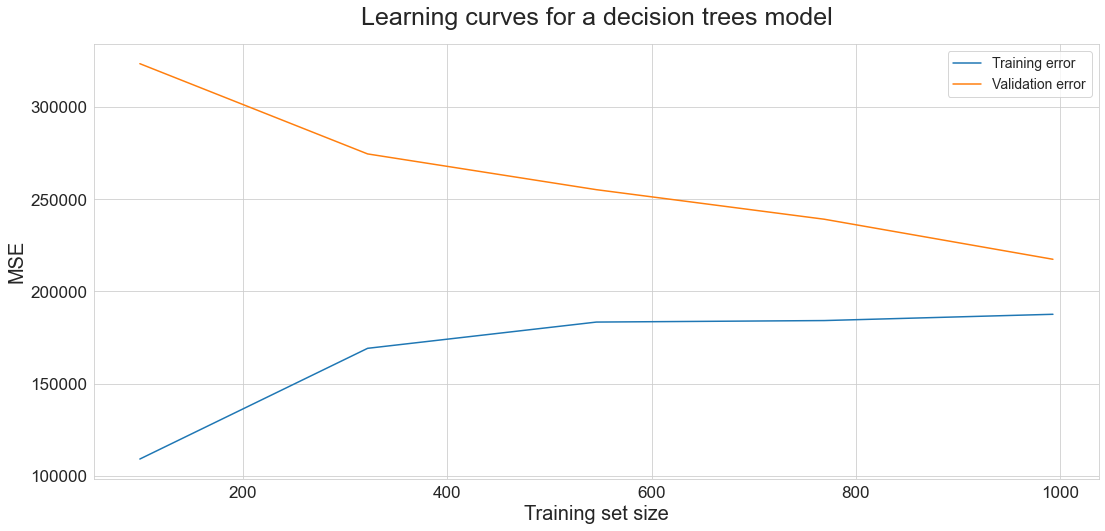

In [54]:
plt.figure(figsize=(18,8))
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')

# oSet labels and title
plt.ylabel('MSE', fontsize = 20)
plt.xlabel('Training set size', fontsize = 20)
plt.title('Learning curves for a decision trees model', fontsize = 25, y = 1.03)
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17)
plt.legend(fontsize=14)

The plot shows a slight improvement from the linear regression model. As with the previous model, both the training and validation errors converge as the size of the training set increases. However, in this case, the validation error is lower than that of the linear regression model, indicating a better performance.

In [55]:
residuals = y_test - y_pred

# Get summary statistics of the residuals using describe()
residuals.describe()

count     249.000000
mean      -31.020378
std       430.072774
min     -1451.634615
25%      -256.286517
50%       -46.850000
75%       163.713483
max      2314.578947
Name: price, dtype: float64

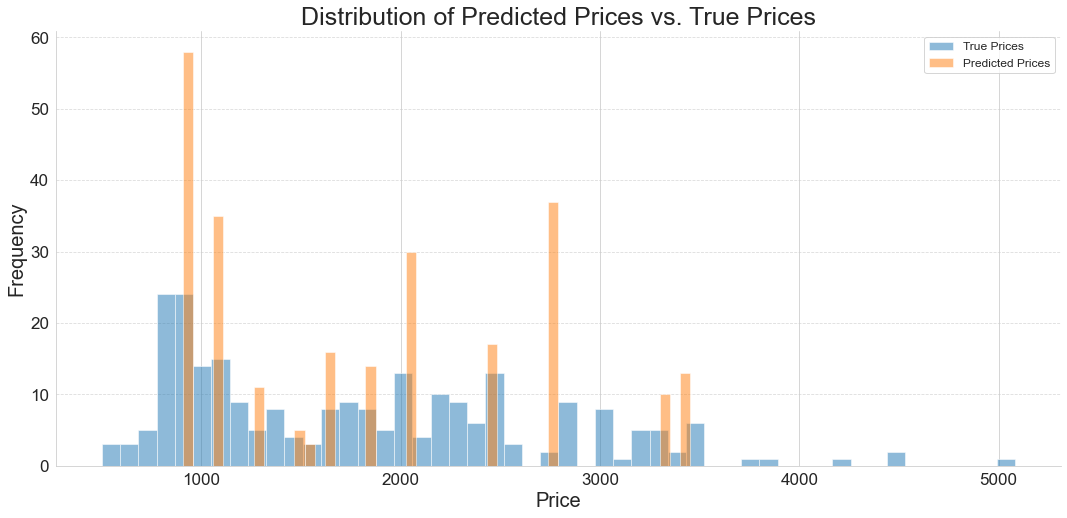

In [56]:
fig, ax = plt.subplots(figsize=(18, 8))

# create a histogram with both sets of data
ax.hist(y_test, alpha=0.5, label='True Prices', bins=50)
ax.hist(y_pred, alpha=0.5, label='Predicted Prices', bins=50)

# set axis labels and title
ax.set_xlabel('Price', fontsize=20)
ax.set_ylabel('Frequency', fontsize=20)
ax.set_title('Distribution of Predicted Prices vs. True Prices', fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=17)

# set legend location and font size
ax.legend(fontsize=12, loc='upper right')

# remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# add gridlines
ax.grid(axis='y', linestyle='--', alpha=0.7)

# show the plot
plt.show()

Here we can observe a plot depicting the distribution of predicted price vs actual price. It is evident that the decision tree model performed poorly in predicting prices. There are 11 noticeable peaks in the predicted price distribution that the decision tree model usually outputs. Additionally, the distribution of predicted price does not resemble the actual price distribution, indicating that the decision tree model did not learn the underlying patterns in the data accurately.

## Random Forest

The next model that I plan to build is a random forest. Random forests typically perform better than decision trees, so I anticipate that this model will produce superior results.

In [57]:
# Define the model
rf_model = RandomForestRegressor(random_state=42)

# Define the parameter grid for pruning
param_grid = {
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4],
}

# Perform a grid search to find the best hyperparameters
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_

# Train the model on the training set using the best hyperparameters
best_rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_rf.predict(X_test)

rf_r2 = r2_score(y_test, y_pred)
rf_mse = mean_squared_error(y_test, y_pred)
rf_mae = mean_absolute_error(y_test, y_pred)

print("Rˆ2 in random forest:", rf_r2)
print("MSE in random forest:", rf_mse)
print("MAE in random forest:", rf_mae)

Rˆ2 in random forest: 0.788561260837054
MSE in random forest: 171727.5491440435
MAE in random forest: 284.4151697399289


Similarly, for this model, I conducted a grid search to identify the optimal set of hyperparameters. By testing various combinations of hyperparameters, I aimed to find the configuration that produced the lowest error.

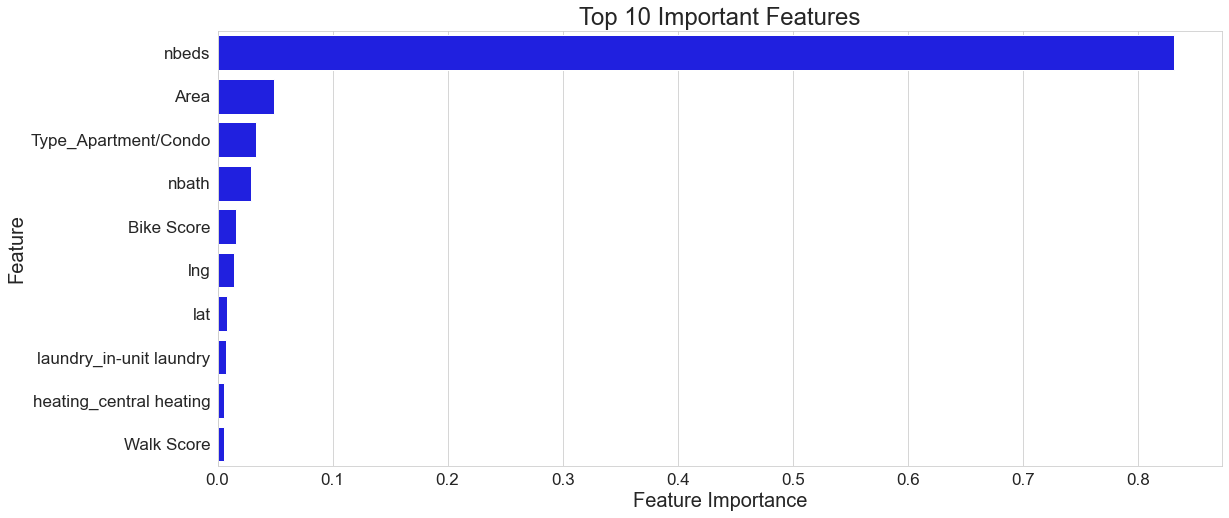

In [58]:
# Get feature importances from the best random forest model
importances = best_rf.feature_importances_

# Get the names of the features
feature_names = X_train.columns.tolist()

# Create a dataframe of feature importances
feature_importances_df = pd.DataFrame({'feature': feature_names, 'importance': importances})

# Sort the dataframe by feature importance in descending order
feature_importances_df = feature_importances_df.sort_values('importance', ascending=False)

# Plot the feature importances as a bar chart
plt.figure(figsize=(18, 8))
sns.barplot(x='importance', y='feature', data=feature_importances_df[0:10], color='b')
plt.xlabel('Feature Importance', fontsize=20)
plt.ylabel('Feature', fontsize=20)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.title('Top 10 Important Features', fontsize = 24)
plt.show()

The plot displays the top 10 most important features for building the price prediction model using the random forest algorithm. The most crucial factor for predicting the price, according to this model, is the number of beds.

In [59]:
# Generate learning curve
train_sizes, train_scores, test_scores = learning_curve(best_rf, X, y, cv=5, scoring = 'neg_mean_squared_error', shuffle = True)

# Calculate mean training and validation scores
train_scores_mean = -train_scores.mean(axis=1)
validation_scores_mean = -test_scores.mean(axis=1)

print('Mean training scores\n\n', pd.Series(train_scores_mean, index=train_sizes))
print('\n', '-' * 20)  # separator
print('\nMean validation scores\n\n', pd.Series(validation_scores_mean, index=train_sizes))

Mean training scores

 99      83930.142526
322    118732.825374
546    129057.446492
769    142503.783540
993    149502.985541
dtype: float64

 --------------------

Mean validation scores

 99     262742.878747
322    243213.266806
546    229181.542268
769    219935.939670
993    213639.418138
dtype: float64


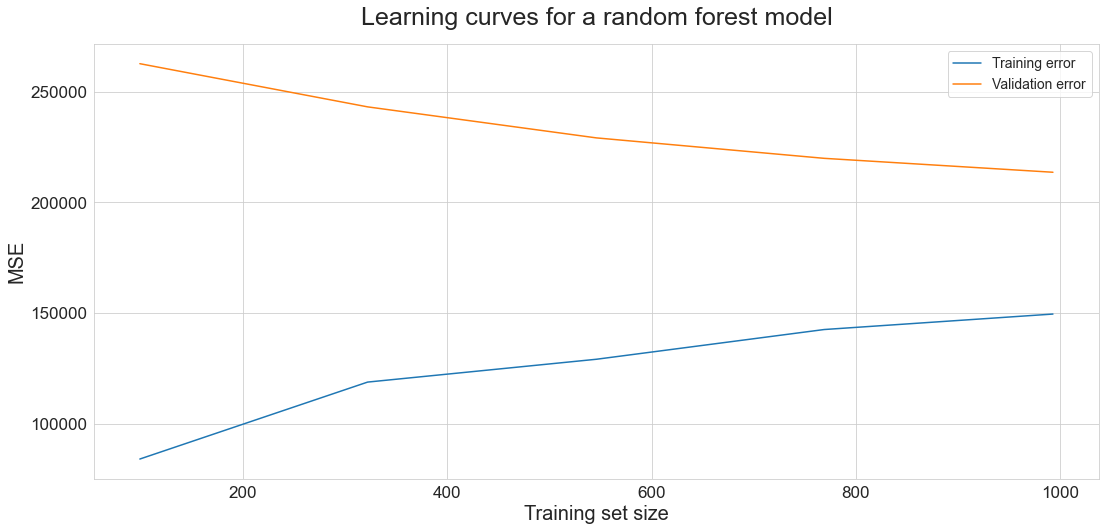

In [60]:
plt.figure(figsize=(18,8))
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')

plt.ylabel('MSE', fontsize = 20)
plt.xlabel('Training set size', fontsize = 20)
plt.title('Learning curves for a random forest model', fontsize = 25, y = 1.03)
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17)
plt.legend(fontsize=14)

The plot illustrates that the training and validation errors converge towards each other, but the gap between the two curves is much larger than in the previous plots. This suggests that the model has a high variance, which is an undesirable trait. A high variance indicates that the model is overly complex and may not generalize well to new data.

In [61]:
residuals = y_test - y_pred

# Get summary statistics of the residuals using describe()
residuals.describe()

count     249.000000
mean      -33.238302
std       413.897040
min     -1489.971436
25%      -212.975766
50%       -46.203873
75%       162.566501
max      2163.473053
Name: price, dtype: float64

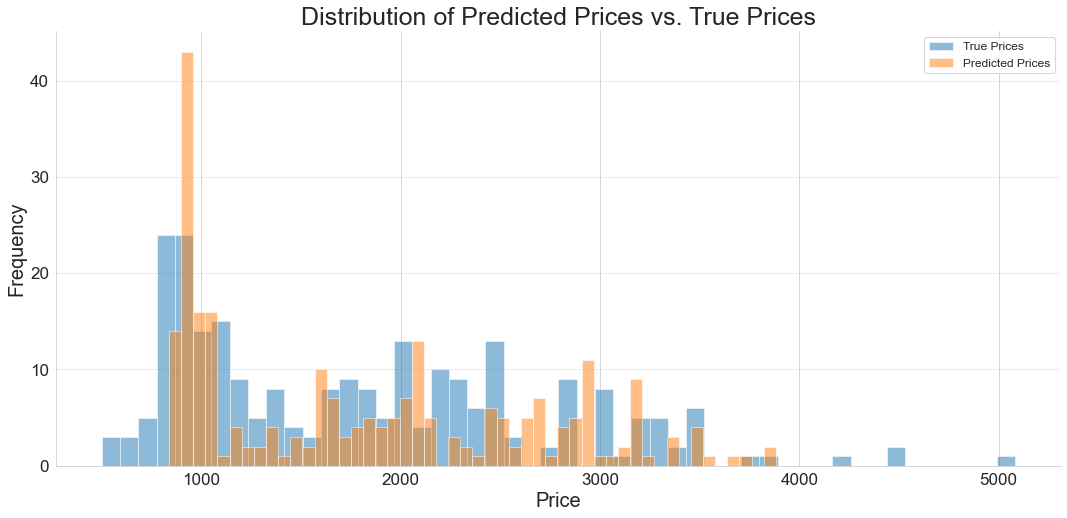

In [62]:
fig, ax = plt.subplots(figsize=(18, 8))

# create a histogram with both sets of data
ax.hist(y_test, alpha=0.5, label='True Prices', bins=50)
ax.hist(y_pred, alpha=0.5, label='Predicted Prices', bins=50)

# set axis labels and title
ax.set_xlabel('Price', fontsize=20)
ax.set_ylabel('Frequency', fontsize=20)
ax.set_title('Distribution of Predicted Prices vs. True Prices', fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=17)

# set legend location and font size
ax.legend(fontsize=12, loc='upper right')

# remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# add gridlines
ax.grid(axis='y', linestyle='--', alpha=0.7)

# show the plot
plt.show()

Here we can see a plot showing the distribution of predicted price versus actual price. The random forest model has done a good job with predicting prices overall, but we can observe a significant peak at the price of 1000, which has been predicted more than other prices. Additionally, like other models, the random forest model also struggles to predict lower prices.

## Gradient boosting

The next model I will use is gradient boosting, which is one of the most powerful algorithms for regression problems. For this task, I will be using the Xgboost library because it has demonstrated exceptional performance and works well with datasets that have a low number of rows, unlike gbmlight.

In [63]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

# define the hyperparameters for the XGBoost model
params = {
    'objective': 'reg:squarederror',
    'max_depth': 5,
    'learning_rate': 0.05,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
    'min_child_weight': 3,
    'n_jobs': -1
}
evals_result = {}

# create the training and validation datasets for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_test, label=y_test)

# train the XGBoost model
xgb_model = xgb.train(params,
                      dtrain,
                      num_boost_round=5000,
                      evals=[(dtrain, 'train'), (dval, 'val')],
                      early_stopping_rounds=10,
                      verbose_eval=10,
                      evals_result=evals_result)


# predict the target values for the test data
y_pred = xgb_model.predict(dval)

# calculate the mean squared error and R^2 score
xgb_mse = mean_squared_error(y_test, y_pred)
xgb_r2 = r2_score(y_test, y_pred)
xgb_mae = mean_absolute_error(y_test, y_pred)

# print the results
print('Mean squared error: {:.4f}'.format(xgb_mse))
print('R^2 score: {:.4f}'.format(xgb_r2))
print('MAE: {:.4f}'.format(xgb_mae))

[0]	train-rmse:1989.24352	val-rmse:1905.91298
[10]	train-rmse:1253.42042	val-rmse:1175.72952
[20]	train-rmse:827.44065	val-rmse:766.32450
[30]	train-rmse:590.08838	val-rmse:548.82502
[40]	train-rmse:466.06796	val-rmse:450.68375
[50]	train-rmse:403.49752	val-rmse:414.41573
[60]	train-rmse:369.77375	val-rmse:403.81186
[70]	train-rmse:350.39060	val-rmse:402.21687
[76]	train-rmse:342.11721	val-rmse:402.70635
Mean squared error: 162172.4028
R^2 score: 0.8003
MAE: 271.5177


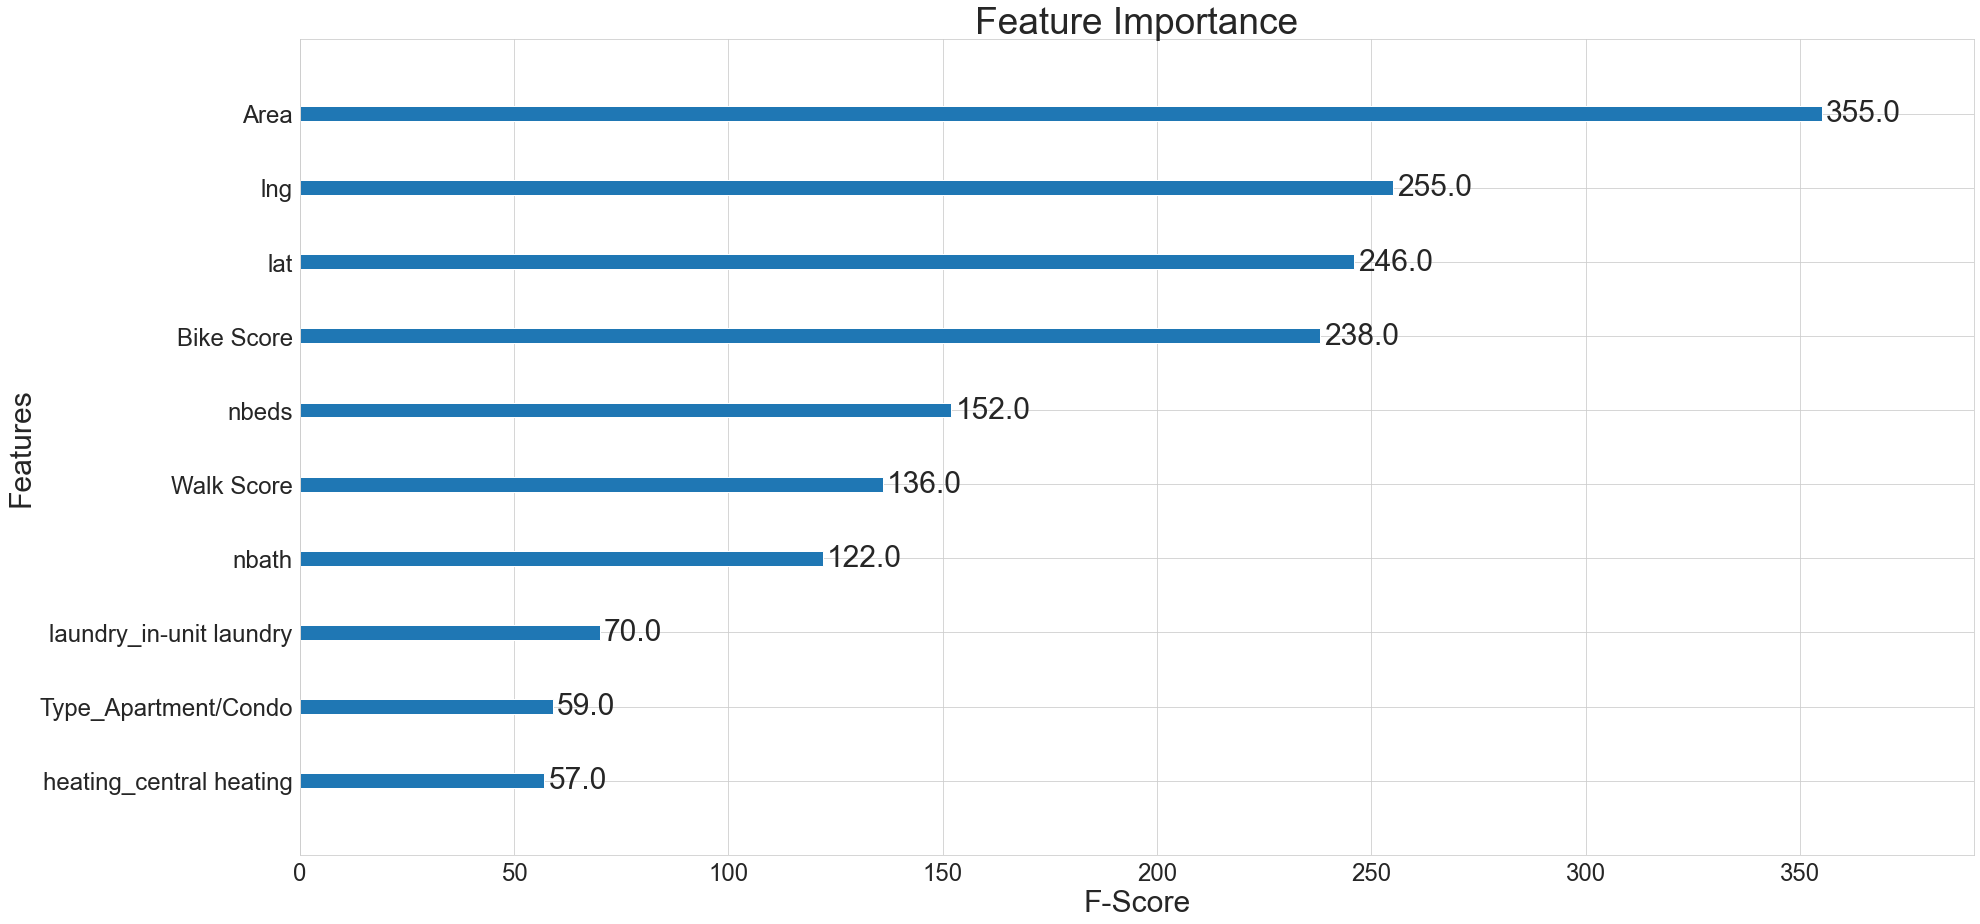

In [64]:
fig, ax = plt.subplots(figsize=(30, 15))
xgb.plot_importance(xgb_model, ax=ax)
ax.set_xlabel('F-Score', fontsize=30)
ax.set_ylabel('Features', fontsize=30)
ax.set_title('Feature Importance', fontsize=37)
ax.tick_params(axis='both', which='major', labelsize=24)
plt.show()

This plot shows the top 10 features for the Gradient boosting model. The difference between random forest and gradient boosting is evident, with this model placing more importance on features such as Area, latitude, and longitude, and ranking the number of beds in fifth place.

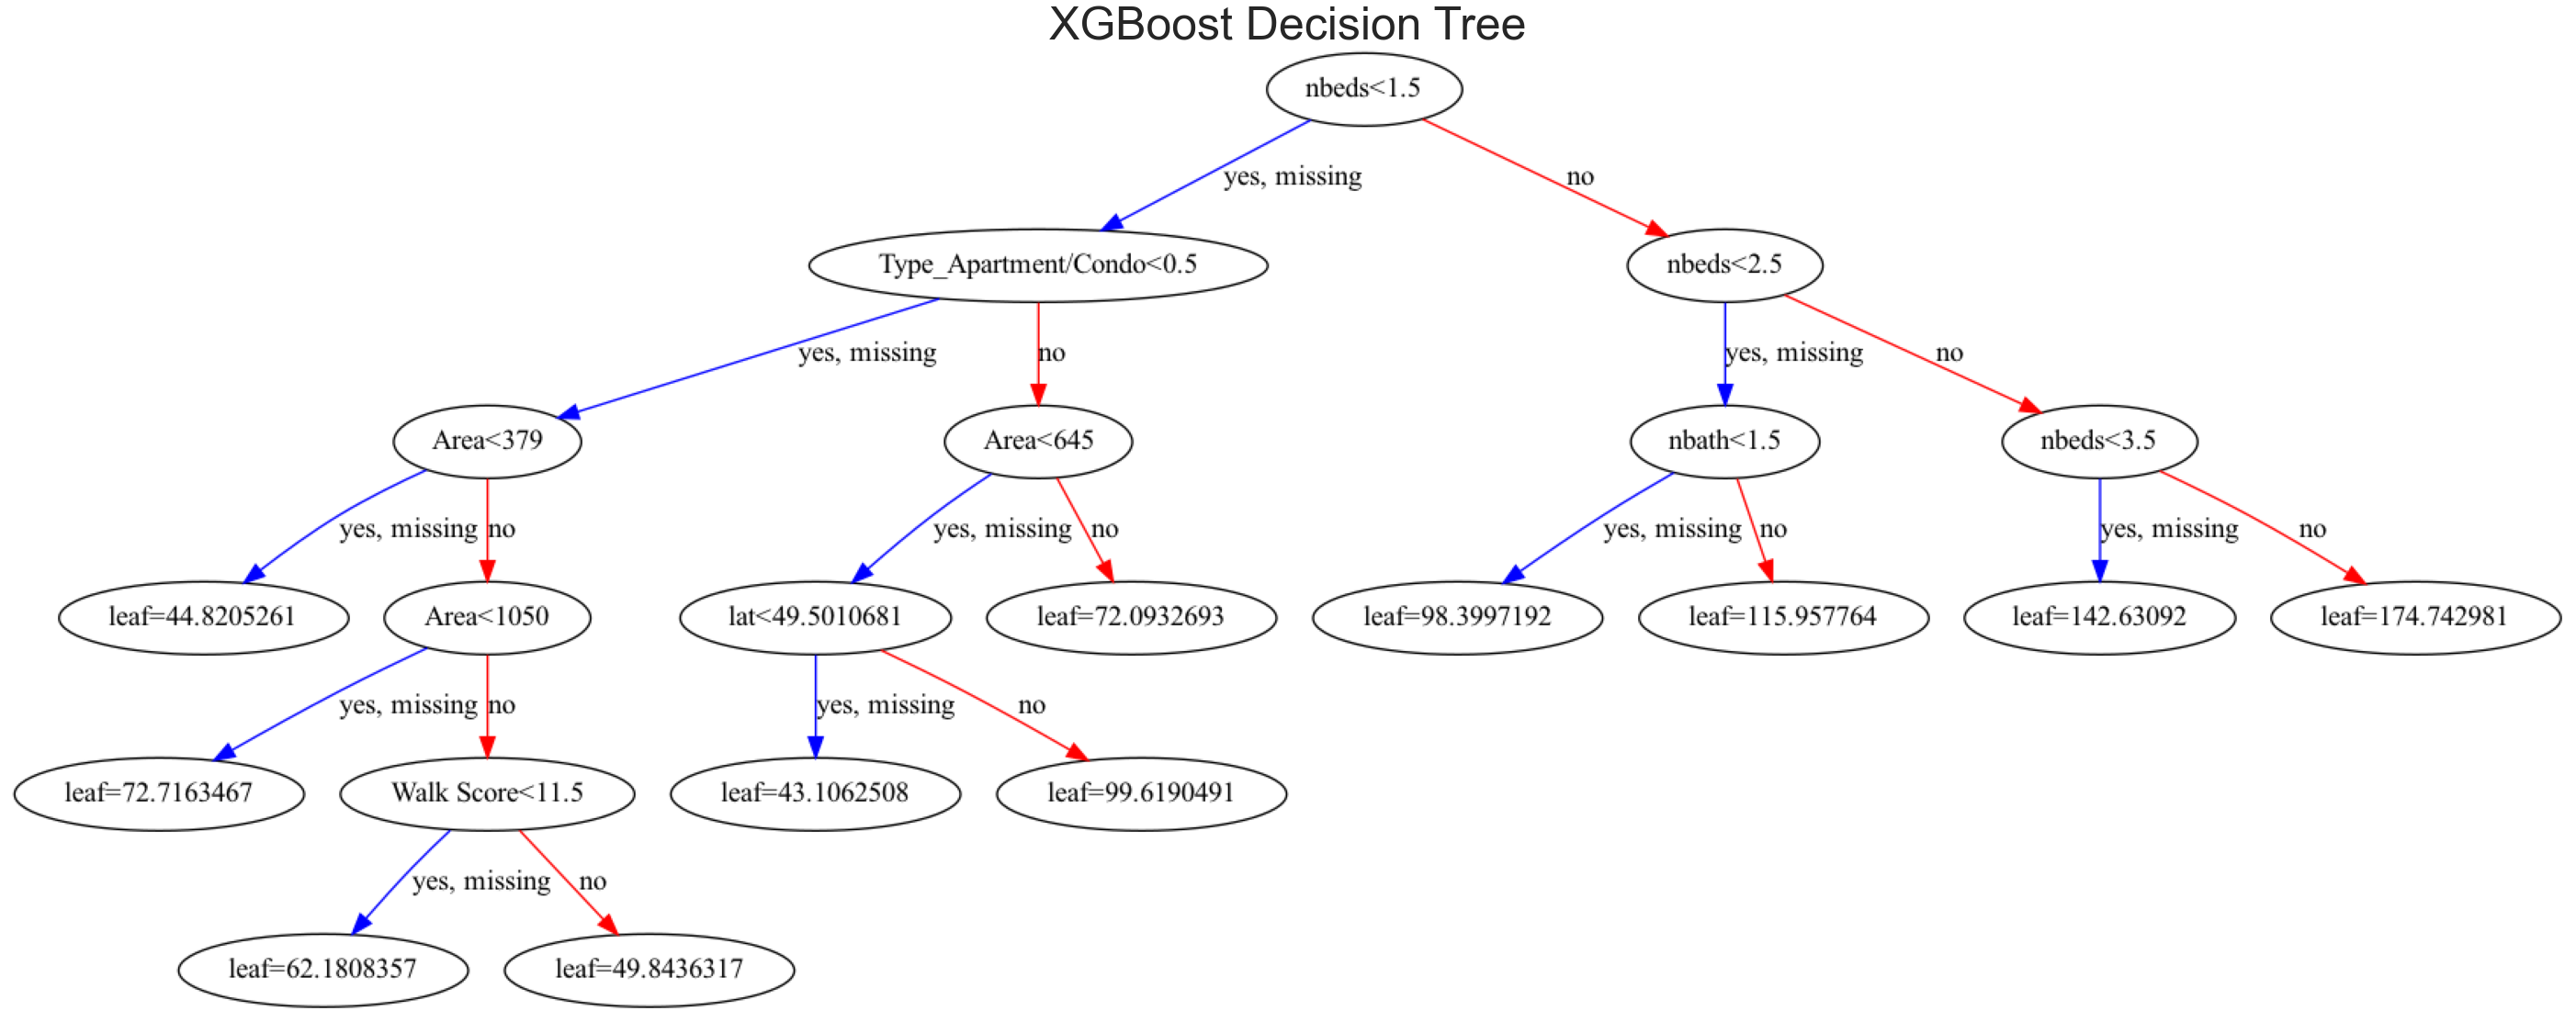

In [65]:
fig, ax = plt.subplots(figsize=(50, 50))
xgb.plot_tree(xgb_model, ax=ax, num_trees=0)
plt.rcParams.update({'font.size': 30})
plt.ylabel('Feature', fontsize=40)
plt.xlabel('Split value', fontsize=40)
plt.title('XGBoost Decision Tree', fontsize=50)
plt.show()

 Overall, the plot provides a visual representation of the decision-making process used by the model to make predictions. It can be useful in understanding which features are most important in making accurate predictions, and how the model is using those features to make decisions.

In [70]:
residuals = y_test - y_pred

# Get summary statistics of the residuals using describe()
residuals.describe()

count     249.000000
mean       -0.416884
std       403.517223
min     -1542.601318
25%      -169.641113
50%         6.951782
75%       173.023376
max      2181.542236
Name: price, dtype: float64

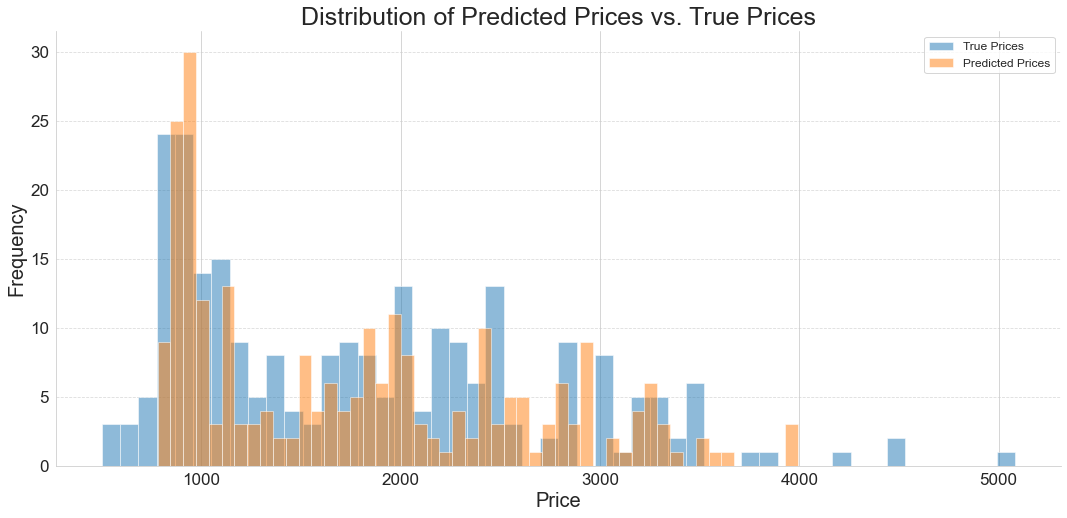

In [67]:
fig, ax = plt.subplots(figsize=(18, 8))

# create a histogram with both sets of data
ax.hist(y_test, alpha=0.5, label='True Prices', bins=50)
ax.hist(y_pred, alpha=0.5, label='Predicted Prices', bins=50)

# set axis labels and title
ax.set_xlabel('Price', fontsize=20)
ax.set_ylabel('Frequency', fontsize=20)
ax.set_title('Distribution of Predicted Prices vs. True Prices', fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=17)

# set legend location and font size
ax.legend(fontsize=12, loc='upper right')

# remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# add gridlines
ax.grid(axis='y', linestyle='--', alpha=0.7)

# show the plot
plt.show()

Based on the analysis, it is evident that the model struggles with accurately predicting lower prices, particularly for rooms. However, the model performs reasonably well overall in predicting prices. On the other hand, the model shows poor performance in predicting extremely high prices, such as 4000 and higher.

## Results

In this section, I will compare the predictions made by all the methods I have used so far. The final results are summarized in the table below. I have used the mean absolute error (MAE), mean squared error (MSE), and R squared (R^2) for each model.

| Metric | Linear Regression | Decision Trees | Random Forest | Gradient Boosting |
|--------|-------------------|----------------|---------------|-------------------|
| R^2    | 0.74              | 0.78           | 0.79          |      0.80        |
| MAE    | 316.67            | 295.78         | 284.42        |      271.5        |
| MSE    | 214739.78         | 185182.03      | 171727.55     |  162172.40          |


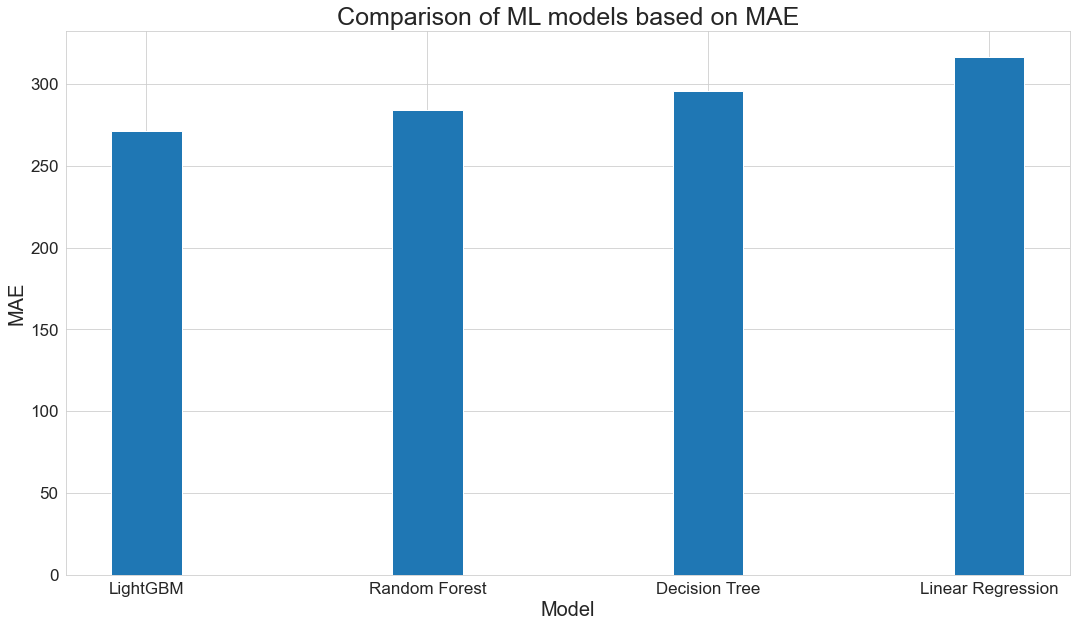

In [68]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(18, 10))

# Define the model names and their respective evaluation metrics
models = ['LightGBM', 'Random Forest', 'Decision Tree', 'Linear Regression']
mae_scores = [xgb_mae, rf_mae, dtree_mae, lr_mae]

# Set the width of the bars
barWidth = 0.25

# Set the x positions of the bars
r1 = np.arange(len(models))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# Create the bar chart
plt.bar(r2, mae_scores, width=barWidth, edgecolor='white', label='MAE')

# Add xticks on the middle of the group bars
plt.xticks([r + barWidth for r in range(len(models))], models)

# Add legend and labels
plt.xlabel('Model', fontsize=20)
plt.ylabel('MAE', fontsize=20)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.title('Comparison of ML models based on MAE', fontsize = 25)
plt.show()

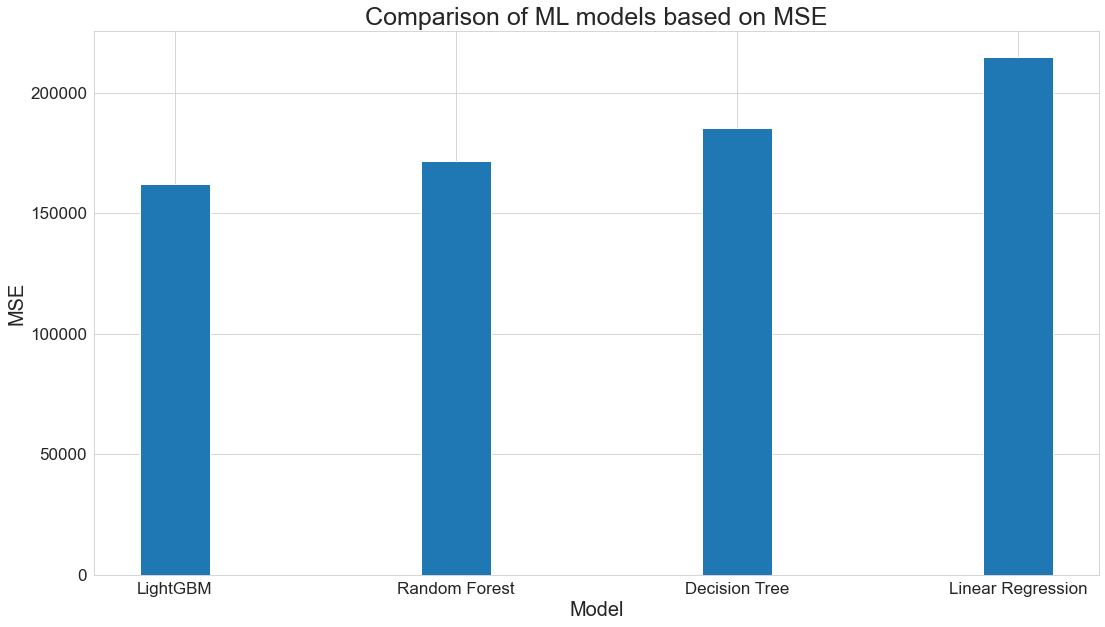

In [69]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(18, 10))

# Define the model names and their respective evaluation metrics
models = ['LightGBM', 'Random Forest', 'Decision Tree', 'Linear Regression']
mse_scores = [xgb_mse, rf_mse, dtree_mse, lr_mse]

# Set the width of the bars
barWidth = 0.25

# Set the x positions of the bars
r1 = np.arange(len(models))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# Create the bar chart
plt.bar(r2, mse_scores, width=barWidth, edgecolor='white', label='MSE')

# Add xticks on the middle of the group bars
plt.xticks([r + barWidth for r in range(len(models))], models)

# Add legend and labels
plt.xlabel('Model', fontsize=20)
plt.ylabel('MSE', fontsize=20)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.title('Comparison of ML models based on MSE', fontsize = 25)
plt.show()

It can be observed from the table that Gradient Boosting outperforms all other models based on R^2, MAE, and MSE metrics. Therefore, Gradient Boosting will be utilized for developing the web application.

In [72]:
import joblib
# Let’s save the Gradient Boosting model
joblib.dump(best_rf, 'fhs_xgb_model.pkl')

['fhs_rf_model.pkl']